# Bayesian Networks and Flight Delay : SFO to PHL

Flight delay is a costly problem to consumers, airlines, and industrial experts. Delays provoke complaints from passengers, create high costs to airlines, and result in difficulties for airport operations. It is therefore important for the Federal Aviation Administration (FAA) to understand the causes of delay as a means to reduce the total cost that delays can cause.

Known factors that cause flight delays include weather at the origin airport, congestion at the origin airport, and air traffic management (ATM) decisions such as Ground Delay Programs (GDP). Each component interacts with other components in complex ways, which is why flight delays are an inherently stochastic phenomenon. Simply examining the marginal distributions of such factor does not truly reveal the effects that such factors have or the relationship between any two of such factors.

Here, we will perform a case study of the use of Bayesian networks to model the relationship between different components of aircraft delay and the causal factors that affect delays. Bayesian networks allow us to simultaneously examine multiple components of delay and their relationships in a single analysis, an advantage that the use of Bayesian networks has over linear and nonlinear regression models. Moreover, Bayesian network models provide not only just predictions of future delays that incorporate the interrelationships among causal factors, but also a means of assessing the ultimate influence each causal factors has on arrival delay.

In particular, we will examine delays in flight from San Francisco International Airport (SFO) to Philadelphia International Airport (PHL).

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import time
import calendar
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
def filterRoutes(df):
    '''
    filter df to contain delayed fligths from SFO to PHL routes only.
    '''
    df = df[(df['ORIGIN'] == 'SFO') & (df['DEST'] == 'PHL') & (df['ARR_DELAY'] > 0)]
    df = df.reset_index()
    return df.drop(['index','YEAR','ORIGIN','DEST', 'UNIQUE_CARRIER','DEP_TIME','DEP_TIME_BLK','DEP_DELAY_GROUP', 'DEP_DELAY_NEW', 'DEP_DEL15','WHEELS_OFF','WHEELS_ON','ARR_DELAY','ARR_DELAY_NEW','Unnamed: 29'],axis=1)

def dateColumns(df):
    '''
    Given a column with mm/dd/yyyy, create a MONTH and DAY column.
    '''
    dates = [str(d).replace('/','') for d in list(df['Date'])]
    dates = [time.strptime(d,'%m%d%Y') for d in dates]
    df['MONTH'] = [d.tm_mon for d in dates]
    df['DAY'] = [d.tm_mday for d in dates]

## The Nitty-Gritty: Preparing the Data

### Read and Merge

We are working with two datasets. The first is provided by the Bureau of Transportation Statistics and contains flight information, including Common Reporting Standard (CRS) arrival and departure times, causes of delay, and time spend taxiing in and out. We will start by reading in twelve months' worth of data and filtering for just the SFO to PHL routes.

In [3]:
# read data and filter for relevant delayed flights
jan_df = filterRoutes(pd.read_csv('./month/jan2017.csv'))
feb_df = filterRoutes(pd.read_csv('./month/feb2017.csv'))
mar_df = filterRoutes(pd.read_csv('./month/mar2017.csv'))
apr_df = filterRoutes(pd.read_csv('./month/apr2017.csv'))
may_df = filterRoutes(pd.read_csv('./month/may2017.csv'))
jun_df = filterRoutes(pd.read_csv('./month/jun2017.csv'))
jul_df = filterRoutes(pd.read_csv('./month/jul2017.csv'))
aug_df = filterRoutes(pd.read_csv('./month/aug2017.csv'))
sep_df = filterRoutes(pd.read_csv('./month/sep2017.csv'))
oct_df = filterRoutes(pd.read_csv('./month/oct2017.csv'))
nov_df = filterRoutes(pd.read_csv('./month/nov2017.csv'))
dec_df = filterRoutes(pd.read_csv('./month/dec2017.csv'))

# concatenate dataframes by quarter
flights_df = pd.concat([jan_df, feb_df,mar_df,apr_df, may_df, jun_df, jul_df, aug_df, sep_df, oct_df, nov_df, dec_df])

# keep hour information from CRS but not minutes
flights_df['CRS_DEP_TIME'] = flights_df['CRS_DEP_TIME'] // 100
flights_df['CRS_ARR_TIME'] = flights_df['CRS_ARR_TIME'] // 100

Secondly, we will read in the data provided by the Federal Aviation Administration (FAA) on airport situations in SFO and PHL in 2017 in 'ASPM : Airport Analysis : Delayed Flights Report.' After reading in the data, we will merge the two dataframes to create one flights_df dataframe.

In [4]:
airports_df = pd.read_csv('./faa-aspm/airports.csv').dropna(axis=0,how='all')

# split Date into MONTH and DAY
airports_df['Facility'] = airports_df['Facility'].str.strip()
dateColumns(airports_df)
airports_df = airports_df.drop(['Date','% DelayedGateDepartures','% DelayedGateArrivals','Date'],axis=1)
airports_df = airports_df.drop(['DeparturesFor MetricComputation','ArrivalsFor MetricComputation','AverageMinutesOf DelayPer DelayedGateDeparture','AverageMinutesOf DelayPer DelayedGateArrival'],axis=1)

# find departure and arrival informations at airport at time of departure/arrival
# SFO (departure)
flights_SFO_df = pd.merge(flights_df, airports_df, how='inner', left_on=['MONTH','DAY_OF_MONTH','CRS_DEP_TIME'], right_on=['MONTH','DAY','Hour'])
flights_SFO_df = flights_SFO_df[flights_SFO_df['Facility'] == 'SFO']
# PHL (arrival)
flights_PHL_df = pd.merge(flights_df, airports_df, how='inner', left_on=['MONTH','DAY_OF_MONTH','CRS_DEP_TIME'], right_on=['MONTH','DAY','Hour'])
flights_PHL_df = flights_PHL_df[flights_PHL_df['Facility'] == 'PHL']
# set departure/arrival information as fields of flights_df
flights_df['DelayedDepartureSFO'] = flights_PHL_df['DelayedGateDepartures']
flights_df['ScheduledDepartureSFO'] = flights_PHL_df['ScheduledDepartures']
flights_df['DelayedArrivalPHL'] = flights_PHL_df['DelayedGateArrivals']
flights_df['ScheduledArrivalPHL'] = flights_PHL_df['ScheduledArrivals']
flights_df.fillna(0,inplace=True)
flights_df = flights_df.reset_index()
flights_df = flights_df.drop(['index'],axis=1)

We no longer need information about DAY_OF_MONTH, so we will drop that column. The compiled data is as below. Due to the length of each field name, we transpose the dataframe for readability.

In [5]:
flights_df = flights_df.drop(['DAY_OF_MONTH'],axis=1)
flights_df.transpose()

,0,1,2,3,4,5,6,7,8,9,...,958,959,960,961,962,963,964,965,966,967
QUARTER,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
MONTH,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
DAY_OF_WEEK,3.0,6.0,4.0,6.0,7.0,1.0,2.0,4.0,5.0,4.0,...,4.0,4.0,3.0,2.0,1.0,2.0,1.0,7.0,5.0,4.0
CRS_DEP_TIME,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,...,15.0,8.0,8.0,8.0,8.0,8.0,22.0,22.0,8.0,22.0
DEP_DELAY,28.0,90.0,32.0,24.0,-1.0,0.0,-9.0,17.0,2.0,1.0,...,81.0,23.0,-1.0,-6.0,14.0,10.0,-5.0,0.0,35.0,0.0
TAXI_OUT,26.0,12.0,17.0,16.0,29.0,16.0,19.0,24.0,23.0,31.0,...,20.0,29.0,39.0,36.0,45.0,21.0,29.0,27.0,29.0,27.0
TAXI_IN,3.0,5.0,4.0,6.0,4.0,6.0,5.0,3.0,3.0,7.0,...,5.0,6.0,5.0,5.0,8.0,11.0,11.0,7.0,10.0,5.0
CRS_ARR_TIME,6.0,6.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,0.0,17.0,16.0,16.0,16.0,16.0,7.0,7.0,16.0,7.0
ARR_DEL15,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
DIVERTED,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Train and Test Data

Let the five delay causes (CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY) and the variable we are looking to explain (ARR_DEL15) be nodes. We must perform regression analysis to determine dependency relationships.

In [6]:
# 20% test data
from sklearn.model_selection import train_test_split
# 774 train data, 194 test data
train_df,test_df = train_test_split(flights_df, test_size=0.2)

## Finding Dependencies: Regression Analysis

We use the Ordinary Least Squares (OLS) method to find dependencies, starting with what we know to be the final outcome: ARR_DEL15 (which is 0 if the flight does not arrive more than 15 minutes late, 1 otherwise). As we find dependencies, we will also be making sure that we are not creating any accidental cycles.

In [7]:
bn = nx.DiGraph()
flight_edges_df = pd.DataFrame(columns=['from_node', 'to_node'])

In [8]:
def regression_model(from_li, to_node):
    '''
    return OLS regression model, given list from_li of nodes and singular to_node
    '''
    X = train_df[from_li]
    y = train_df[to_node]
    model = sm.OLS(y, X).fit()
    return model

def update_flights_edges_df(from_li, str_var, flight_edges_df):
    '''
    update dataframe of edges using a list of from nodes, the string value of the node,
    and the current dataframe of edges.
    '''
    # update flights_edges_df with from_node to to_node entries
    flights_edges_dict = dict()
    for node in from_li:
        flights_edges_dict[node] = str_var
    temp_df = pd.DataFrame(list(flights_edges_dict.items()), columns=['from_node', 'to_node'])
    flight_edges_df = pd.concat([flight_edges_df, temp_df]).reset_index()
    flight_edges_df = flight_edges_df.drop(['index'], axis=1)

    # create network
    bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())
    
    # check to see if there are cycles, print one cycle if there exists at least one
    try:
        print(nx.find_cycle(bn, source=None, orientation='original'))
    except:
        print('No cycle found! You may proceed.')
        
    return flight_edges_df, bn

def draw_graph(df,name):
    '''
    takes in dataframe of edges (from_node, to_node) and plots directed graph
    saves to name
    '''
    # create network
    G = nx.from_pandas_edgelist(df,source='from_node',target='to_node',create_using=nx.DiGraph())

    G_edges = [edge for edge in G.edges()]
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), node_size = 200,alpha=0.3)
    nx.draw_networkx_labels(G, pos,font_size='10')
    nx.draw_networkx_edges(G, pos, edgelist=G_edges, edge_color='b',style='dot', arrows=True,arrow_size = 15,alpha=0.5)
    plt.savefig('./images/'+ name)
    plt.show()
    
def remove_edge(from_edge,to_edge,df):
    '''
    remove from_edge to to_edge directed edge from df
    '''
    # remove edge from df
    df = df[(flight_edges_df.from_node != from_edge) | (flight_edges_df.to_node != to_edge)]
    
    # create network
    G = nx.from_pandas_edgelist(df,source='from_node',target='to_node',create_using=nx.DiGraph())
    # check for cycles
    try:
        print(nx.find_cycle(G, source=None, orientation='original'))
    except:
        print('No cycle found! You may proceed.')
    return df, G

### ARR_DEL15

In [9]:
arr_15_from = ['CRS_DEP_TIME','DEP_DELAY','CRS_ARR_TIME','CARRIER_DELAY','NAS_DELAY','LATE_AIRCRAFT_DELAY']
regression_model(arr_15_from, 'ARR_DEL15').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ARR_DEL15   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     319.7
Date:                Sun, 08 Apr 2018   Prob (F-statistic):          6.10e-205
Time:                        00:50:37   Log-Likelihood:                -373.45
No. Observations:                 774   AIC:                             758.9
Df Residuals:                     768   BIC:                             786.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
CRS_DEP_TIME            0.0155      0.001     11.514      0.000       0.013       0.018
DEP_DELAY              -0.0036      0.001     -4.168      0.000      -0.005      -0.002
CRS_ARR_TIME            0.0095      0.001      6.522      0.000       0.007       0.012
CARRIER_DELAY           0.0064      0.001      6.673      0.000       0.005       0.008
NAS_DELAY               0.0131      0.001     16.421      0.000       0.012       0.015
LATE_AIRCRAFT_DELAY     0.0124      0.001     10.039      0.000       0.010       0.015
==============================================================================
Omnibus:                       15.085   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               18.387
Skew:                          -0.242   Prob(JB):                     0.000102
Kurtosis:                       3.579   Cond. No.                         8.01
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

No cycle found! You may proceed.


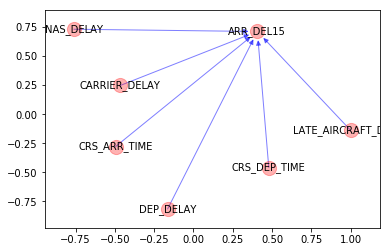

In [10]:
# update dataframe of edges and draw graph
flight_edges_df, bn = update_flights_edges_df(arr_15_from, 'ARR_DEL15',flight_edges_df)
draw_graph(flight_edges_df,'initial_bn.png')

Using regressional analysis, we conclude that ARR_DEL15 is dependent on six factors. So far, we do not have any cycles (remember that a Bayesian network consists of a directed acyclic graph), so we may proceed by moving onto finding more dependencies by choosing an arbitrary parent of ARR_DEL15.

### NAS Delay

Carrier Delay depends on

In [11]:
nas_delay_from = ['QUARTER','CRS_DEP_TIME','DEP_DELAY','TAXI_OUT','TAXI_IN','CRS_ARR_TIME','DIVERTED','CARRIER_DELAY','WEATHER_DELAY','LATE_AIRCRAFT_DELAY']
regression_model(nas_delay_from, 'NAS_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              NAS_DELAY   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     144.9
Date:                Sun, 08 Apr 2018   Prob (F-statistic):          9.18e-159
Time:                        00:50:37   Log-Likelihood:                -3089.2
No. Observations:                 774   AIC:                             6196.
Df Residuals:                     765   BIC:                             6238.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
QUARTER                -2.1953      0.428     -5.134      0.000      -3.035      -1.356
CRS_DEP_TIME           -0.6397      0.069     -9.226      0.000      -0.776      -0.504
DEP_DELAY               0.6429      0.029     22.509      0.000       0.587       0.699
TAXI_OUT                0.8434      0.042     20.020      0.000       0.761       0.926
TAXI_IN                 0.8331      0.055     15.178      0.000       0.725       0.941
CRS_ARR_TIME           -0.6825      0.079     -8.690      0.000      -0.837      -0.528
DIVERTED            -7.288e-16   6.98e-17    -10.437      0.000   -8.66e-16   -5.92e-16
CARRIER_DELAY          -0.6513      0.032    -20.578      0.000      -0.713      -0.589
WEATHER_DELAY          -0.5970      0.084     -7.142      0.000      -0.761      -0.433
LATE_AIRCRAFT_DELAY    -0.7156      0.040    -17.763      0.000      -0.795      -0.637
==============================================================================
Omnibus:                      163.156   Durbin-Watson:                   2.106
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              428.738
Skew:                           1.074   Prob(JB):                     7.96e-94
Kurtosis:                       5.946   Cond. No.                     1.12e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.5e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [12]:
flight_edges_df, bn = update_flights_edges_df(nas_delay_from, 'NAS_DELAY',flight_edges_df)

No cycle found! You may proceed.


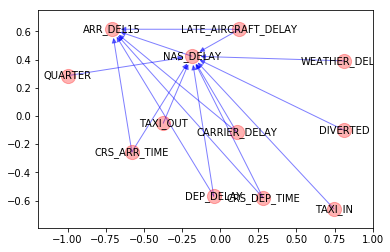

In [13]:
draw_graph(flight_edges_df, 'nas-arr_del15.png')

### Late Aircraft Delay

Now, we took a look at the variables that LATE_AIRCRAFT_DELAY rely on. From this point on, we will not display the graph.

In [14]:
late_aircraft_from = ['MONTH','DEP_DELAY','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY']
regression_model(late_aircraft_from, 'LATE_AIRCRAFT_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     LATE_AIRCRAFT_DELAY   R-squared:                       0.741
Model:                             OLS   Adj. R-squared:                  0.740
Method:                  Least Squares   F-statistic:                     440.9
Date:                 Sun, 08 Apr 2018   Prob (F-statistic):          5.39e-223
Time:                         00:50:37   Log-Likelihood:                -2948.2
No. Observations:                  774   AIC:                             5906.
Df Residuals:                      769   BIC:                             5930.
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
MONTH             0.2972      0.056      5.262      0.000       0.186       0.408
DEP_DELAY         0.6017      0.014     43.802      0.000       0.575       0.629
CARRIER_DELAY    -0.6058      0.018    -32.881      0.000      -0.642      -0.570
WEATHER_DELAY    -0.6115      0.067     -9.140      0.000      -0.743      -0.480
NAS_DELAY        -0.2345      0.020    -11.464      0.000      -0.275      -0.194
==============================================================================
Omnibus:                      265.861   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10253.425
Skew:                          -0.828   Prob(JB):                         0.00
Kurtosis:                      20.754   Cond. No.                         10.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
flight_edges_df, bn = update_flights_edges_df(late_aircraft_from, 'LATE_AIRCRAFT_DELAY',flight_edges_df)

[('NAS_DELAY', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'NAS_DELAY')]


Since __NAS_DELAY__ and __LATE_AIRCRAFT_DELAY__ have edges pointing to each other, we must decide which edge we are going to get rid of. The FAA (http://aspmhelp.faa.gov/index.php/Types_of_Delay) defines __NAS_DELAY__ as delay that is "within the control of the National Airspace System (NAS)," including "non-extreme weather conditions, airport operations, heavy traffic volume, air traffic control, etc." It goes on to state that delays at the destination airport that occur after Actual Gate Out time are attributed to the NAS (such as gate in delay and taxi in delay). On the other hand, FAA defines __LATE_AIRCRAFT_DELAY__ as arrival delay due to the ripple effect of an earlier delay at downstream airports is referred to as delay propagation. That is, the two seem to have no direct relationship with one another at all. Therefore, we remove both edges.

In [16]:
# remove both edges
flight_edges_df, _ = remove_edge('NAS_DELAY','LATE_AIRCRAFT_DELAY', flight_edges_df)
flight_edges_df, bn = remove_edge('LATE_AIRCRAFT_DELAY','NAS_DELAY', flight_edges_df)

No cycle found! You may proceed.
No cycle found! You may proceed.


### Carrier Delay

In [17]:
carrier_delay_from = ['CRS_DEP_TIME','DEP_DELAY','TAXI_OUT','TAXI_IN','CRS_ARR_TIME','DIVERTED','WEATHER_DELAY','NAS_DELAY','LATE_AIRCRAFT_DELAY']
regression_model(carrier_delay_from, 'CARRIER_DELAY').summary()

/opt/conda/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1471: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          CARRIER_DELAY   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     813.3
Date:                Sun, 08 Apr 2018   Prob (F-statistic):               0.00
Time:                        00:50:37   Log-Likelihood:                -3024.6
No. Observations:                 774   AIC:                             6065.
Df Residuals:                     766   BIC:                             6102.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
CRS_DEP_TIME           -0.5967      0.059    -10.096      0.000      -0.713      -0.481
DEP_DELAY               0.8793      0.011     78.105      0.000       0.857       0.901
TAXI_OUT                0.5523      0.041     13.322      0.000       0.471       0.634
TAXI_IN                 0.5425      0.053     10.197      0.000       0.438       0.647
CRS_ARR_TIME           -0.7022      0.067    -10.490      0.000      -0.834      -0.571
DIVERTED            -1.992e-17    2.6e-18     -7.670      0.000    -2.5e-17   -1.48e-17
WEATHER_DELAY          -0.8391      0.073    -11.445      0.000      -0.983      -0.695
NAS_DELAY              -0.5367      0.026    -20.406      0.000      -0.588      -0.485
LATE_AIRCRAFT_DELAY    -0.9695      0.026    -37.132      0.000      -1.021      -0.918
==============================================================================
Omnibus:                      207.878   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9452.597
Skew:                          -0.350   Prob(JB):                         0.00
Kurtosis:                      20.106   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [18]:
flight_edges_df, bn = update_flights_edges_df(carrier_delay_from, 'CARRIER_DELAY',flight_edges_df)

[('NAS_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'NAS_DELAY')]


__CARRIER_DELAY__ is within the control of the air carrier, such as: aircraft cleaning, aircraft damage, awaiting the arrival of connecting passengers or crew, baggage, bird strike, cargo loading, catering, computer, outage-carrier equipment, crew legality (pilot or attendant rest), damage by hazardous goods, engineering inspection, fueling, handling disabled passengers, late crew, lavatory servicing, maintenance, oversales, potable water servicing, removal of unruly passenger, slow boarding or seating, stowing carry-on baggage, weight and balance delays. This seems to have little to do with __NAS_DELAY__ and vice versa. Thus, we remove both edges

In [19]:
# remove both edges
flight_edges_df, _ = remove_edge('CARRIER_DELAY','NAS_DELAY', flight_edges_df)
flight_edges_df, bn = remove_edge('NAS_DELAY','CARRIER_DELAY', flight_edges_df)

[('CARRIER_DELAY', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY')]
[('CARRIER_DELAY', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY')]


Recall that FAA defines __LATE_AIRCRAFT_DELAY__ as arrival delay due to the ripple effect of an earlier delay at downstream airports is referred to as delay propagation. It would seem probable that a late prior aircraft could cause carrier delay but not the other way around. Thus, we only remove the edge from CARRIER_DELAY to LATE_AIRCRAFT_DELAY.

In [20]:
flight_edges_df, bn = remove_edge('CARRIER_DELAY','LATE_AIRCRAFT_DELAY', flight_edges_df)

No cycle found! You may proceed.


### WEATHER_DELAY

Though not ideal in p-value, CRS_DEP_TIME seems like the only likely variable which WEATHER_DELAY may be dependent on.

In [21]:
weather_delay_from = ['CRS_DEP_TIME']
regression_model(weather_delay_from, 'WEATHER_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          WEATHER_DELAY   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.306
Date:                Sun, 08 Apr 2018   Prob (F-statistic):              0.129
Time:                        00:50:38   Log-Likelihood:                -2485.2
No. Observations:                 774   AIC:                             4972.
Df Residuals:                     773   BIC:                             4977.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CRS_DEP_TIME     0.0215      0.014      1.519      0.129      -0.006       0.049
==============================================================================
Omnibus:                     2032.158   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         18952277.197
Skew:                          27.650   Prob(JB):                         0.00
Kurtosis:                     767.598   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
flight_edges_df, bn = update_flights_edges_df(weather_delay_from, 'WEATHER_DELAY',flight_edges_df)

No cycle found! You may proceed.


### Security Delay

Security delay is caused by evacuation of a terminal or concourse, re-boarding of aircraft because of security breach, inoperative screening equipment and/or long lines in excess of 29 minutes at screening areas.

In [23]:
security_delay_from = ['DAY_OF_WEEK','DEP_DELAY','TAXI_OUT','CARRIER_DELAY','NAS_DELAY','LATE_AIRCRAFT_DELAY']
regression_model(security_delay_from, 'SECURITY_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         SECURITY_DELAY   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     3.172
Date:                Sun, 08 Apr 2018   Prob (F-statistic):            0.00442
Time:                        00:50:38   Log-Likelihood:                -1643.9
No. Observations:                 774   AIC:                             3300.
Df Residuals:                     768   BIC:                             3328.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
DAY_OF_WEEK            -0.0616      0.030     -2.035      0.042      -0.121      -0.002
DEP_DELAY               0.0164      0.005      3.529      0.000       0.007       0.025
TAXI_OUT                0.0106      0.005      2.250      0.025       0.001       0.020
CARRIER_DELAY          -0.0171      0.005     -3.324      0.001      -0.027      -0.007
NAS_DELAY              -0.0103      0.005     -2.257      0.024      -0.019      -0.001
LATE_AIRCRAFT_DELAY    -0.0118      0.007     -1.793      0.073      -0.025       0.001
==============================================================================
Omnibus:                     2007.347   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         17474855.408
Skew:                          26.814   Prob(JB):                         0.00
Kurtosis:                     737.153   Cond. No.                         26.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
flight_edges_df, bn = update_flights_edges_df(security_delay_from, 'SECURITY_DELAY',flight_edges_df)

No cycle found! You may proceed.


### Calendar Quarter

We come to a rather interesting (not entirely unlikely) conclusion that CRS_DEP_TIME and CRS_ARR_TIME may directly influence QUARTER.

In [25]:
quarter_from = ['MONTH','CRS_DEP_TIME','CRS_ARR_TIME']
regression_model(quarter_from, 'QUARTER').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                QUARTER   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 2.748e+04
Date:                Sun, 08 Apr 2018   Prob (F-statistic):               0.00
Time:                        00:50:38   Log-Likelihood:                -105.94
No. Observations:                 774   AIC:                             217.9
Df Residuals:                     771   BIC:                             231.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
MONTH            0.3236      0.003    111.619      0.000       0.318       0.329
CRS_DEP_TIME     0.0108      0.001      9.106      0.000       0.008       0.013
CRS_ARR_TIME     0.0179      0.001     14.696      0.000       0.015       0.020
==============================================================================
Omnibus:                     1501.137   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.616
Skew:                           0.025   Prob(JB):                     1.38e-12
Kurtosis:                       1.700   Cond. No.                         6.42
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
flight_edges_df, bn = update_flights_edges_df(quarter_from, 'QUARTER',flight_edges_df)

No cycle found! You may proceed.


### Departure Delay

This is the difference in minutes between scheduled and actual departure time. Early departures show negative numbers.

In [27]:
departure_delay_from = ['QUARTER','MONTH','DAY_OF_WEEK','CRS_DEP_TIME','TAXI_OUT','TAXI_IN','CRS_ARR_TIME','DIVERTED','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','LATE_AIRCRAFT_DELAY']
regression_model(departure_delay_from, 'DEP_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              DEP_DELAY   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     1119.
Date:                Sun, 08 Apr 2018   Prob (F-statistic):               0.00
Time:                        00:50:38   Log-Likelihood:                -3066.1
No. Observations:                 774   AIC:                             6154.
Df Residuals:                     763   BIC:                             6205.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
QUARTER                 6.8689      1.667      4.122      0.000       3.597      10.141
MONTH                  -2.0380      0.555     -3.672      0.000      -3.128      -0.948
DAY_OF_WEEK             0.4626      0.227      2.041      0.042       0.018       0.907
CRS_DEP_TIME            0.5675      0.072      7.903      0.000       0.427       0.709
TAXI_OUT               -0.6835      0.044    -15.501      0.000      -0.770      -0.597
TAXI_IN                -0.6421      0.056    -11.396      0.000      -0.753      -0.531
CRS_ARR_TIME            0.6732      0.083      8.070      0.000       0.509       0.837
DIVERTED             5.796e-16   3.14e-16      1.848      0.065   -3.61e-17     1.2e-15
CARRIER_DELAY           1.0110      0.013     79.092      0.000       0.986       1.036
WEATHER_DELAY           0.9625      0.077     12.507      0.000       0.811       1.114
NAS_DELAY               0.6145      0.027     22.512      0.000       0.561       0.668
LATE_AIRCRAFT_DELAY     1.1222      0.024     47.061      0.000       1.075       1.169
==============================================================================
Omnibus:                      314.429   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3435.472
Skew:                           1.519   Prob(JB):                         0.00
Kurtosis:                      12.864   Cond. No.                     4.77e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.11e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [28]:
flight_edges_df, bn = update_flights_edges_df(departure_delay_from,'DEP_DELAY',flight_edges_df)

[('NAS_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'NAS_DELAY')]


It is not very likely that an NAS-related delay causes a security-related delay. Therefore, we will remove the edge from NAS_DELAY to SECURITY_DELAY.

In [29]:
flight_edges_df, bn = remove_edge('NAS_DELAY','SECURITY_DELAY', flight_edges_df)

[('NAS_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'NAS_DELAY')]


Departure time is the time recorded when the plane's parking brakes are released, which is after doors are closed and just prior to the plane beginning to taxi. That is, departure time starts right before a plan leaves its gate. Therefore, while it is likely that a difference in CRS departure time and actual departure time causes an NAS delay, it is impossible for NAS delay to influence the departure time difference. Thus, we remove the edge from NAS_DELAY to DEP_DELAY.

In [30]:
flight_edges_df, bn = remove_edge('NAS_DELAY','DEP_DELAY', flight_edges_df)

[('CARRIER_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY')]


Departure delay cannot lead to a late aircraft delay: this is temporally impossible, so we get rid of that directed edge.

In [31]:
flight_edges_df, bn = remove_edge('DEP_DELAY', 'LATE_AIRCRAFT_DELAY', flight_edges_df)

[('CARRIER_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'CARRIER_DELAY')]


Again, temporally, departure delay cannot lead to a carrier delay. Therefore, we remove that directed edge.

In [32]:
flight_edges_df, bn = remove_edge('DEP_DELAY', 'CARRIER_DELAY', flight_edges_df)

No cycle found! You may proceed.


By the same reasoning as above, we remove the edge from DEP_DELAY to SECURITY_DELAY.

In [33]:
flight_edges_df, bn = remove_edge('DEP_DELAY', 'SECURITY_DELAY', flight_edges_df)

No cycle found! You may proceed.


### Taxi Out

Taxi Out Time, in Minutes.

In [34]:
taxi_out_from = ['QUARTER','CRS_DEP_TIME','DEP_DELAY','TAXI_IN','CRS_ARR_TIME','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','LATE_AIRCRAFT_DELAY']
regression_model(taxi_out_from, 'TAXI_OUT').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TAXI_OUT   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     888.9
Date:                Sun, 08 Apr 2018   Prob (F-statistic):               0.00
Time:                        00:50:38   Log-Likelihood:                -2807.8
No. Observations:                 774   AIC:                             5634.
Df Residuals:                     765   BIC:                             5676.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
QUARTER                 2.2726      0.291      7.811      0.000       1.701       2.844
CRS_DEP_TIME            0.7931      0.042     18.905      0.000       0.711       0.875
DEP_DELAY              -0.3474      0.022    -15.574      0.000      -0.391      -0.304
TAXI_IN                -0.3927      0.041     -9.543      0.000      -0.473      -0.312
CRS_ARR_TIME            0.9335      0.046     20.193      0.000       0.843       1.024
CARRIER_DELAY           0.3330      0.025     13.516      0.000       0.285       0.381
WEATHER_DELAY           0.2701      0.059      4.562      0.000       0.154       0.386
NAS_DELAY               0.4076      0.020     20.020      0.000       0.368       0.448
LATE_AIRCRAFT_DELAY     0.3278      0.031     10.537      0.000       0.267       0.389
==============================================================================
Omnibus:                       39.624   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.951
Skew:                           0.454   Prob(JB):                     1.93e-12
Kurtosis:                       3.921   Cond. No.                         56.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
flight_edges_df, bn = update_flights_edges_df(taxi_out_from,'TAXI_OUT',flight_edges_df)

[('NAS_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'NAS_DELAY')]


In [36]:
flight_edges_df, bn = remove_edge('TAXI_OUT', 'NAS_DELAY', flight_edges_df)

[('NAS_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'NAS_DELAY')]


In [37]:
flight_edges_df, bn = remove_edge('TAXI_OUT', 'CARRIER_DELAY', flight_edges_df)

[('NAS_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'DEP_DELAY'), ('DEP_DELAY', 'NAS_DELAY')]


In [38]:
flight_edges_df, bn = remove_edge('TAXI_OUT', 'SECURITY_DELAY', flight_edges_df)

[('NAS_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'DEP_DELAY'), ('DEP_DELAY', 'NAS_DELAY')]


In [39]:
flight_edges_df, bn = remove_edge('DEP_DELAY', 'NAS_DELAY', flight_edges_df)

[('TAXI_OUT', 'DEP_DELAY'), ('DEP_DELAY', 'TAXI_OUT')]


In [40]:
flight_edges_df, bn = remove_edge('DEP_DELAY', 'TAXI_OUT', flight_edges_df)

No cycle found! You may proceed.


### Taxi In

In [41]:
taxi_in_from = ['QUARTER','CRS_DEP_TIME','DEP_DELAY','TAXI_OUT','CRS_ARR_TIME','DIVERTED','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','LATE_AIRCRAFT_DELAY']
regression_model(taxi_in_from, 'TAXI_IN').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                TAXI_IN   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     125.0
Date:                Sun, 08 Apr 2018   Prob (F-statistic):          9.53e-144
Time:                        00:50:38   Log-Likelihood:                -2664.2
No. Observations:                 774   AIC:                             5346.
Df Residuals:                     765   BIC:                             5388.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
QUARTER                 1.1972      0.247      4.840      0.000       0.712       1.683
CRS_DEP_TIME            0.3389      0.040      8.390      0.000       0.260       0.418
DEP_DELAY              -0.2225      0.020    -11.302      0.000      -0.261      -0.184
TAXI_OUT               -0.2709      0.028     -9.543      0.000      -0.327      -0.215
CRS_ARR_TIME            0.4553      0.045     10.210      0.000       0.368       0.543
DIVERTED             1.719e-17   3.75e-18      4.590      0.000    9.84e-18    2.45e-17
CARRIER_DELAY           0.2230      0.021     10.469      0.000       0.181       0.265
WEATHER_DELAY           0.1964      0.049      3.980      0.000       0.100       0.293
NAS_DELAY               0.2778      0.018     15.178      0.000       0.242       0.314
LATE_AIRCRAFT_DELAY     0.2464      0.026      9.413      0.000       0.195       0.298
==============================================================================
Omnibus:                     1078.385   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           393613.812
Skew:                           7.253   Prob(JB):                         0.00
Kurtosis:                     112.520   Cond. No.                     2.06e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.46e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [42]:
flight_edges_df, bn = update_flights_edges_df(taxi_in_from,'TAXI_IN',flight_edges_df)

[('NAS_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'DEP_DELAY'), ('DEP_DELAY', 'TAXI_IN'), ('TAXI_IN', 'NAS_DELAY')]


In [43]:
flight_edges_df, bn = remove_edge('TAXI_OUT','DEP_DELAY', flight_edges_df)

[('NAS_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'TAXI_IN'), ('TAXI_IN', 'NAS_DELAY')]


In [44]:
flight_edges_df, bn = remove_edge('TAXI_IN','NAS_DELAY', flight_edges_df)

[('TAXI_IN', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'TAXI_IN')]


In [45]:
flight_edges_df, bn = remove_edge('TAXI_IN','CARRIER_DELAY', flight_edges_df)

[('TAXI_IN', 'DEP_DELAY'), ('DEP_DELAY', 'TAXI_IN')]


In [46]:
flight_edges_df, bn = remove_edge('TAXI_IN','DEP_DELAY', flight_edges_df)

[('TAXI_OUT', 'TAXI_IN'), ('TAXI_IN', 'TAXI_OUT')]


In [47]:
flight_edges_df, bn = remove_edge('TAXI_IN','TAXI_OUT', flight_edges_df)

No cycle found! You may proceed.


### DelayedDepartureSFO

In [48]:
delayed_SFO_from = ['WEATHER_DELAY','ScheduledDepartureSFO','DelayedArrivalPHL','ScheduledArrivalPHL']
regression_model(delayed_SFO_from, 'DelayedDepartureSFO').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     DelayedDepartureSFO   R-squared:                       0.722
Model:                             OLS   Adj. R-squared:                  0.720
Method:                  Least Squares   F-statistic:                     499.6
Date:                 Sun, 08 Apr 2018   Prob (F-statistic):          3.01e-212
Time:                         00:50:38   Log-Likelihood:                -1657.1
No. Observations:                  774   AIC:                             3322.
Df Residuals:                      770   BIC:                             3341.
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
WEATHER_DELAY             0.0268      0.013      2.108      0.035       0.002       0.052
ScheduledDepartureSFO     0.1415      0.005     30.946      0.000       0.133       0.150
DelayedArrivalPHL         0.4182      0.047      8.983      0.000       0.327       0.510
ScheduledArrivalPHL      -0.0408      0.013     -3.026      0.003      -0.067      -0.014
==============================================================================
Omnibus:                      235.999   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1045.319
Skew:                           1.341   Prob(JB):                    1.03e-227
Kurtosis:                       8.022   Cond. No.                         14.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
flight_edges_df, bn = update_flights_edges_df(delayed_SFO_from,'DelayedDepartureSFO',flight_edges_df)

No cycle found! You may proceed.


###   DelayedArrivalPHL

In [50]:
delayed_PHL_from = ['CRS_DEP_TIME','WEATHER_DELAY','DelayedDepartureSFO','ScheduledDepartureSFO','ScheduledArrivalPHL']
regression_model(delayed_PHL_from, 'DelayedArrivalPHL').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      DelayedArrivalPHL   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     621.3
Date:                Sun, 08 Apr 2018   Prob (F-statistic):          3.45e-267
Time:                        00:50:38   Log-Likelihood:                -1418.3
No. Observations:                 774   AIC:                             2847.
Df Residuals:                     769   BIC:                             2870.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
CRS_DEP_TIME             -0.0089      0.004     -2.046      0.041      -0.017      -0.000
WEATHER_DELAY             0.0520      0.009      5.649      0.000       0.034       0.070
DelayedDepartureSFO       0.2248      0.025      8.913      0.000       0.175       0.274
ScheduledDepartureSFO    -0.0434      0.005     -8.899      0.000      -0.053      -0.034
ScheduledArrivalPHL       0.2358      0.006     40.813      0.000       0.224       0.247
==============================================================================
Omnibus:                      485.399   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8288.554
Skew:                           2.521   Prob(JB):                         0.00
Kurtosis:                      18.218   Cond. No.                         11.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
flight_edges_df, bn = update_flights_edges_df(delayed_PHL_from,'DelayedArrivalPHL',flight_edges_df)

[('DelayedDepartureSFO', 'DelayedArrivalPHL'), ('DelayedArrivalPHL', 'DelayedDepartureSFO')]


In [52]:
flight_edges_df, bn = remove_edge('DelayedArrivalPHL','DelayedDepartureSFO', flight_edges_df)

No cycle found! You may proceed.


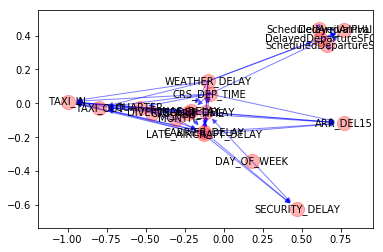

In [53]:
draw_graph(flight_edges_df,'final_bn.png')

In [54]:
nx.is_directed_acyclic_graph(bn), nx.is_tree(bn)

(True, False)

There are 19 nodes and 59 directed edges in this DAG.

In [55]:
# nodes
nodes_df = flight_edges_df['from_node'].drop_duplicates().to_frame()
nodes_df = nodes_df.reset_index().drop(['index'],axis=1)
nodes_df.columns = ['nodes']
flight_edges_df.columns=['Source','Target']
# save as csv
flight_edges_df.to_csv('edges.csv',index=False)
nodes_df.to_csv('nodes.csv',index=False)